<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/48_Expert_FaceRecognition/Expert_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras import Model
from tqdm import tqdm
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
config = {
              "learning_rate": 0.001,
              "epochs": 30,
              "batch_size": 32,
              "log_step": 200,
              "val_log_step": 50,
              # "architecture": "Expert",
              # "dataset": "Face_recognition"
           }

run = wandb.init(project="Expert_Face_Recognition", config=config)
config = wandb.config


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
#hyper parameters
batch_size = 32
epochs = 30
width = height = 224

In [7]:
train_dataset_path = "/content/drive/MyDrive/datasets/Expert_faceRecognition"
idg = ImageDataGenerator(
    rescale= 1./255,
    rotation_range= 10, 
    brightness_range= (0.8, 1.2), 
    zoom_range=0.2,
    horizontal_flip=True,     
    validation_split=0.2   
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"    

)

validation_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

Found 1090 images belonging to 14 classes.
Found 268 images belonging to 14 classes.


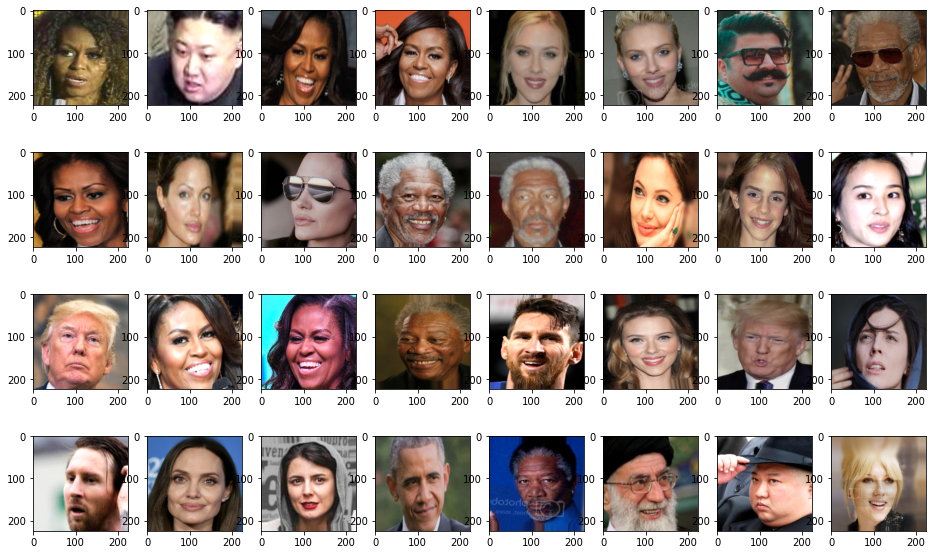

In [10]:
some_images=next(train_data)

X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(16,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])

In [29]:
class ExpertNet(Model):
  def __init__(self):
    super().__init__()

    self.dense_1 = Dense(128, activation="relu")
    self.dense_2 = Dense(64, activation="relu")
    self.dense_3 = Dense(14, activation="softmax")
    self.conv2d_1 = Conv2D(32, (3, 3), activation="relu", input_shape=(width,height,3))
    self.conv2d_2 = Conv2D(64, (3, 3), activation="relu")
    self.conv2d_3=Conv2D(128,(3,3),activation='relu')
    self.conv2d_4=Conv2D(256,(3,3),activation='relu')
    self.flatten = Flatten()
    self.maxpooling = MaxPooling2D
    self.dropout = Dropout(0.1)

  def call(self,x):
    L1= self.conv2d_1(x)  
    p1= self.maxpooling(L1)
    L2= self.conv2d_2(p1)
    p2= self.maxpooling(L2)
    L3= self.conv2d_3(p2)
    p3= self.maxpooling(L3)
    L4= self.conv2d_4(p3)
    p4= self.maxpooling(L4)
    L5= self.flatten(p4)
    L6= self.dense_1(L5)
    d1= self.droupout(L6)  
    L7= self.dense_2(d1)
    out= self.dense_3(L7)
    return out

In [30]:
model = ExpertNet()

In [24]:
optimizer = tf.keras.optimizers.Adam()

loss_function = tf.keras.losses.CategoricalCrossentropy()

In [25]:
train_accuracy = tf.keras.metrics.CategoricalAccuracy()
validation_accuracy = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.MeanAbsoluteError() 
validation_loss = tf.keras.metrics.MeanAbsoluteError()

In [26]:
for epoch in range(epochs):
  train_accuracy.reset_states()
  validation_accuracy.reset_states()
  train_loss.reset_states()
  validation_loss.reset_states()
  print("Epoch:", epoch)
  
  
  # Training----------------------------------------------------------
  # for images, labels in tqdm(train_data):
  for _ in tqdm(range(train_data.samples//batch_size)):
      images, labels = next(train_data)
      with tf.GradientTape() as gTape:
        predictions = model(images) 
        loss = loss_function(labels, predictions)

        train_loss(labels, predictions)
        train_accuracy(labels, predictions)

      # calc gradients
      gradients = gTape.gradient(loss, model.trainable_variables)

      # update weights 
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  # validation--------------------------------------------------
  for _ in tqdm(range(validation_data.samples//batch_size)):
      images, labels = next(validation_data)
      predictions = model(images) 
      loss = loss_function(labels, predictions)
      
      validation_loss(labels, predictions)
      validation_accuracy(labels, predictions)
      
  
  print("Train Accuracy:", train_accuracy.result())
  print("val Accuracy:", validation_accuracy.result())
  print("Train Loss:", train_loss.result())
  print("val Loss:", validation_loss.result())

  wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss.result()),
                   'acc': float(train_accuracy.result()), 
                   'val_loss': np.mean(validation_loss.result()),
                   'val_acc':float(validation_accuracy.result())})
  
  ep = "epoch_{}".format(epoch)
  dir = "/content/drive/MyDrive/models/Expert/47_FaceRecognition"
  name = "{}_{}.HDF5".format(dir, ep)
  print(name)
  model.save_weights(name, save_format='HDF5')
  # model.save(name)
  

Epoch: 0


100%|██████████| 8/8 [01:50<00:00, 13.87s/it]


Train Accuracy: tf.Tensor(0.11247637, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.22265625, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.13086645, shape=(), dtype=float32)
val Loss: tf.Tensor(0.12328173, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_0.HDF5
Epoch: 1


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Train Accuracy: tf.Tensor(0.3988658, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.45338982, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.104753934, shape=(), dtype=float32)
val Loss: tf.Tensor(0.09802121, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_1.HDF5
Epoch: 2


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.547259, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.529661, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0862329, shape=(), dtype=float32)
val Loss: tf.Tensor(0.08335811, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_2.HDF5
Epoch: 3


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.66729677, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.6059322, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.07006955, shape=(), dtype=float32)
val Loss: tf.Tensor(0.07489838, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_3.HDF5
Epoch: 4


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.70699435, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.62288135, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.060450498, shape=(), dtype=float32)
val Loss: tf.Tensor(0.06678928, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_4.HDF5
Epoch: 5


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.7561437, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.6779661, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.051407132, shape=(), dtype=float32)
val Loss: tf.Tensor(0.060358837, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_5.HDF5
Epoch: 6


100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.79395086, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.65254235, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0448202, shape=(), dtype=float32)
val Loss: tf.Tensor(0.05834562, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_6.HDF5
Epoch: 7


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.81285447, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7033898, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.038615257, shape=(), dtype=float32)
val Loss: tf.Tensor(0.049253847, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_7.HDF5
Epoch: 8


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.84499055, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7415254, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.031644445, shape=(), dtype=float32)
val Loss: tf.Tensor(0.045207273, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_8.HDF5
Epoch: 9


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Accuracy: tf.Tensor(0.8705104, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.71875, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.028559733, shape=(), dtype=float32)
val Loss: tf.Tensor(0.047992535, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_9.HDF5
Epoch: 10


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.8851103, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.80932206, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.024165824, shape=(), dtype=float32)
val Loss: tf.Tensor(0.037628446, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_10.HDF5
Epoch: 11


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.879017, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7754237, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.025173632, shape=(), dtype=float32)
val Loss: tf.Tensor(0.042035904, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_11.HDF5
Epoch: 12


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Accuracy: tf.Tensor(0.879017, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8177966, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.02609259, shape=(), dtype=float32)
val Loss: tf.Tensor(0.032814704, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_12.HDF5
Epoch: 13


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.9130435, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.80932206, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.01849852, shape=(), dtype=float32)
val Loss: tf.Tensor(0.035308696, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_13.HDF5
Epoch: 14


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: tf.Tensor(0.90831757, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.80508476, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.019309856, shape=(), dtype=float32)
val Loss: tf.Tensor(0.032778606, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_14.HDF5
Epoch: 15


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.9215501, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7669492, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.017965324, shape=(), dtype=float32)
val Loss: tf.Tensor(0.03686307, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_15.HDF5
Epoch: 16


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.93289226, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7711864, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.014298004, shape=(), dtype=float32)
val Loss: tf.Tensor(0.035200913, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_16.HDF5
Epoch: 17


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.94990546, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.80932206, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.011087492, shape=(), dtype=float32)
val Loss: tf.Tensor(0.031224973, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_17.HDF5
Epoch: 18


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Accuracy: tf.Tensor(0.9536862, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.76953125, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0104464395, shape=(), dtype=float32)
val Loss: tf.Tensor(0.035053782, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_18.HDF5
Epoch: 19


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.8827977, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84322035, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.025302976, shape=(), dtype=float32)
val Loss: tf.Tensor(0.028996427, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_19.HDF5
Epoch: 20


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.94423443, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7923729, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0126419235, shape=(), dtype=float32)
val Loss: tf.Tensor(0.032023985, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_20.HDF5
Epoch: 21


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.952741, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.83474576, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.010743641, shape=(), dtype=float32)
val Loss: tf.Tensor(0.028404968, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_21.HDF5
Epoch: 22


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Accuracy: tf.Tensor(0.963138, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8559322, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.008868851, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024664408, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_22.HDF5
Epoch: 23


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Accuracy: tf.Tensor(0.9253308, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.7966102, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.015255757, shape=(), dtype=float32)
val Loss: tf.Tensor(0.033703487, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_23.HDF5
Epoch: 24


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: tf.Tensor(0.9517958, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.88559324, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.010537571, shape=(), dtype=float32)
val Loss: tf.Tensor(0.021883171, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_24.HDF5
Epoch: 25


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Accuracy: tf.Tensor(0.9678639, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.008129111, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024323614, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_25.HDF5
Epoch: 26


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Accuracy: tf.Tensor(0.9706994, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8601695, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.006738694, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024353916, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_26.HDF5
Epoch: 27


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Accuracy: tf.Tensor(0.9536862, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.82421875, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.009458335, shape=(), dtype=float32)
val Loss: tf.Tensor(0.02951546, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_27.HDF5
Epoch: 28


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train Accuracy: tf.Tensor(0.96219283, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8305085, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.008905346, shape=(), dtype=float32)
val Loss: tf.Tensor(0.028248176, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_28.HDF5
Epoch: 29


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

Train Accuracy: tf.Tensor(0.96597356, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8220339, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.006874274, shape=(), dtype=float32)
val Loss: tf.Tensor(0.028038613, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition_epoch_29.HDF5


In [27]:
for epoch in range(epochs):
  train_accuracy.reset_states()
  validation_accuracy.reset_states()
  train_loss.reset_states()
  validation_loss.reset_states()
  print("Epoch:", epoch)
  
  
  # Training----------------------------------------------------------
  # for images, labels in tqdm(train_data):
  for _ in tqdm(range(train_data.samples//batch_size)):
      images, labels = next(train_data)
      with tf.GradientTape() as gTape:
        predictions = model(images) 
        loss = loss_function(labels, predictions)

        train_loss(labels, predictions)
        train_accuracy(labels, predictions)

      # calc gradients
      gradients = gTape.gradient(loss, model.trainable_variables)

      # update weights 
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))  
  # validation--------------------------------------------------
  for _ in tqdm(range(validation_data.samples//batch_size)):
      images, labels = next(validation_data)
      predictions = model(images) 
      loss = loss_function(labels, predictions)
      
      validation_loss(labels, predictions)
      validation_accuracy(labels, predictions)
      
  
  print("Train Accuracy:", train_accuracy.result())
  print("val Accuracy:", validation_accuracy.result())
  print("Train Loss:", train_loss.result())
  print("val Loss:", validation_loss.result())

  wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss.result()),
                   'acc': float(train_accuracy.result()), 
                   'val_loss': np.mean(validation_loss.result()),
                   'val_acc':float(validation_accuracy.result())})
  
  ep = "epoch_{}".format(epoch)
  dir = "/content/drive/MyDrive/models/Expert/47_FaceRecognition2"
  name = "{}_{}.HDF5".format(dir, ep)
  print(name)
  model.save_weights(name, save_format='HDF5')
  # model.save(name)
  

Epoch: 0


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.96880907, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8559322, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.006748359, shape=(), dtype=float32)
val Loss: tf.Tensor(0.023202298, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_0.HDF5
Epoch: 1


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.9603025, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.83474576, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.007902775, shape=(), dtype=float32)
val Loss: tf.Tensor(0.026107138, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_1.HDF5
Epoch: 2


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.9782609, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.87711865, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.004934002, shape=(), dtype=float32)
val Loss: tf.Tensor(0.02066715, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_2.HDF5
Epoch: 3


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9763705, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84322035, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.005441114, shape=(), dtype=float32)
val Loss: tf.Tensor(0.027372237, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_3.HDF5
Epoch: 4


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.98393196, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.003830967, shape=(), dtype=float32)
val Loss: tf.Tensor(0.02120418, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_4.HDF5
Epoch: 5


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.98393196, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8177966, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.004003907, shape=(), dtype=float32)
val Loss: tf.Tensor(0.027424758, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_5.HDF5
Epoch: 6


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: tf.Tensor(0.9858223, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85546875, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0035145148, shape=(), dtype=float32)
val Loss: tf.Tensor(0.023087552, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_6.HDF5
Epoch: 7


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.9877127, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84745765, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.002992633, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024158932, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_7.HDF5
Epoch: 8


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.96219283, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8135593, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0072932546, shape=(), dtype=float32)
val Loss: tf.Tensor(0.027626108, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_8.HDF5
Epoch: 9


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9867675, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.80932206, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.00433203, shape=(), dtype=float32)
val Loss: tf.Tensor(0.028673584, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_9.HDF5
Epoch: 10


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9754253, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.87711865, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.004824576, shape=(), dtype=float32)
val Loss: tf.Tensor(0.01997366, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_10.HDF5
Epoch: 11


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9858223, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84745765, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0031958118, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024189154, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_11.HDF5
Epoch: 12


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9810964, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.004352495, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024272041, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_12.HDF5
Epoch: 13


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.979206, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0043679946, shape=(), dtype=float32)
val Loss: tf.Tensor(0.02308237, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_13.HDF5
Epoch: 14


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.98298675, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8559322, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0036919028, shape=(), dtype=float32)
val Loss: tf.Tensor(0.022077104, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_14.HDF5
Epoch: 15


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: tf.Tensor(0.9788603, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84765625, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0046733157, shape=(), dtype=float32)
val Loss: tf.Tensor(0.024280071, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_15.HDF5
Epoch: 16


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.9877127, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0028426172, shape=(), dtype=float32)
val Loss: tf.Tensor(0.021785516, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_16.HDF5
Epoch: 17


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.99338377, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8898305, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0026854954, shape=(), dtype=float32)
val Loss: tf.Tensor(0.016877338, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_17.HDF5
Epoch: 18


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: tf.Tensor(0.9640832, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8601695, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.00671703, shape=(), dtype=float32)
val Loss: tf.Tensor(0.023242122, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_18.HDF5
Epoch: 19


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.98393196, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8559322, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0041061696, shape=(), dtype=float32)
val Loss: tf.Tensor(0.022888344, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_19.HDF5
Epoch: 20


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: tf.Tensor(0.9820416, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84745765, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0036188865, shape=(), dtype=float32)
val Loss: tf.Tensor(0.023607867, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_20.HDF5
Epoch: 21


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9763705, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84322035, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0045054024, shape=(), dtype=float32)
val Loss: tf.Tensor(0.02446205, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_21.HDF5
Epoch: 22


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.9848771, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0034899954, shape=(), dtype=float32)
val Loss: tf.Tensor(0.022926636, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_22.HDF5
Epoch: 23


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.99243855, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8305085, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0022026456, shape=(), dtype=float32)
val Loss: tf.Tensor(0.025147822, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_23.HDF5
Epoch: 24


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: tf.Tensor(0.9943289, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.8984375, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0018027874, shape=(), dtype=float32)
val Loss: tf.Tensor(0.017545328, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_24.HDF5
Epoch: 25


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.9858223, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.87711865, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0029268828, shape=(), dtype=float32)
val Loss: tf.Tensor(0.019325214, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_25.HDF5
Epoch: 26


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: tf.Tensor(0.9820416, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.90254235, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0031933887, shape=(), dtype=float32)
val Loss: tf.Tensor(0.016736953, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_26.HDF5
Epoch: 27


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: tf.Tensor(0.98393196, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.85169494, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.003296781, shape=(), dtype=float32)
val Loss: tf.Tensor(0.02271643, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_27.HDF5
Epoch: 28


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: tf.Tensor(0.98960304, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.83898306, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0024767297, shape=(), dtype=float32)
val Loss: tf.Tensor(0.022447564, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_28.HDF5
Epoch: 29


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

Train Accuracy: tf.Tensor(0.979206, shape=(), dtype=float32)
val Accuracy: tf.Tensor(0.84745765, shape=(), dtype=float32)
Train Loss: tf.Tensor(0.0039471565, shape=(), dtype=float32)
val Loss: tf.Tensor(0.023432782, shape=(), dtype=float32)
/content/drive/MyDrive/models/Expert/47_FaceRecognition2_epoch_29.HDF5


In [28]:
# model.save('/content/drive/MyDrive/models/Expert/47_FaceRecognition.h5')
model.save_weights('/content/drive/MyDrive/models/Expert/47_FaceRecognition2', save_format='HDF5')
